
GradientBoosting Performance:
  R^2 Score:           0.9840
  Mean Squared Error:  72.9487
  Mean Absolute Error: 6.0383
  PHM08 Score (sum):   5748.0022
  PHM08 Score (avg):   1.3928

RandomForest Performance:
  R^2 Score:           0.9384
  Mean Squared Error:  281.5600
  Mean Absolute Error: 11.6250
  PHM08 Score (sum):   429636.7391
  PHM08 Score (avg):   104.1039

Ensemble Performance:
  R^2 Score:           0.9703
  Mean Squared Error:  135.5206
  Mean Absolute Error: 8.1303
  PHM08 Score (sum):   26681.6463
  PHM08 Score (avg):   6.4651
Computing SHAP (fast) for GradientBoosting...


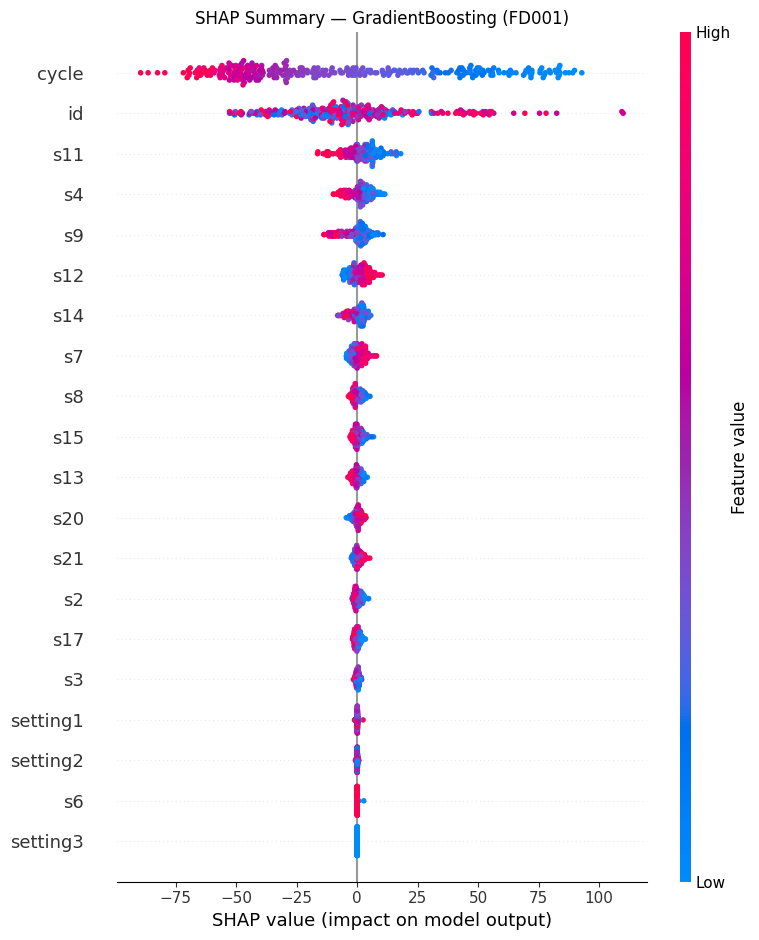

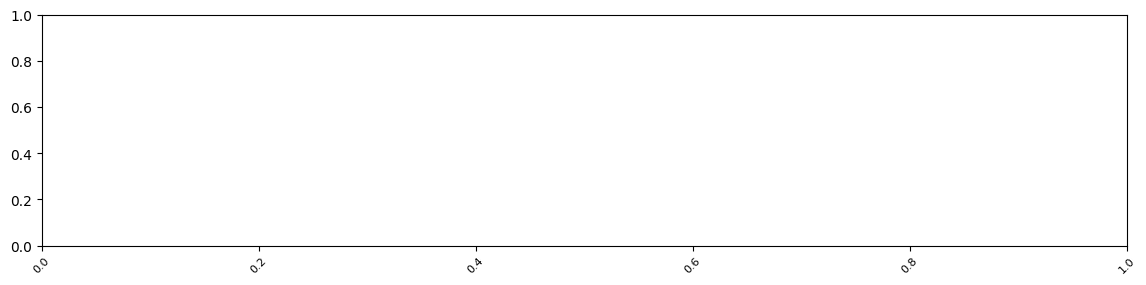

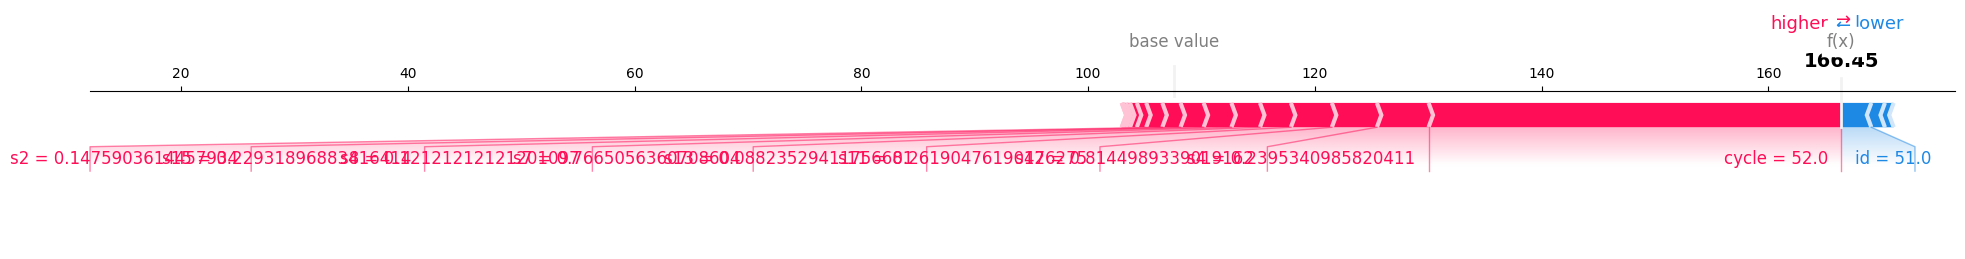

Computing SHAP (fast) for RandomForest...


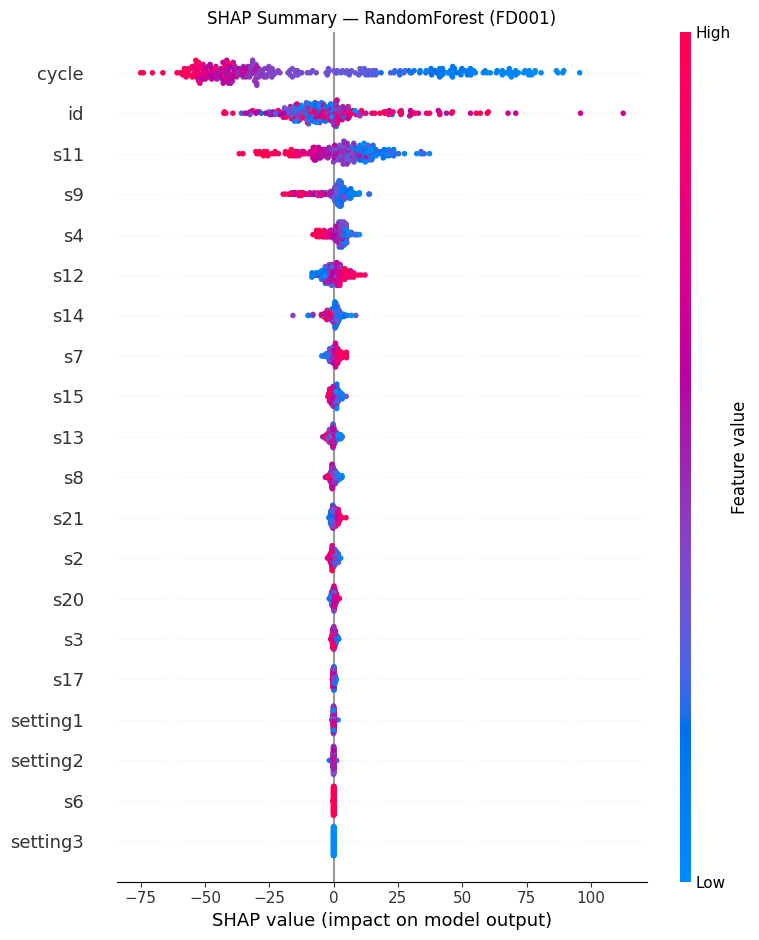

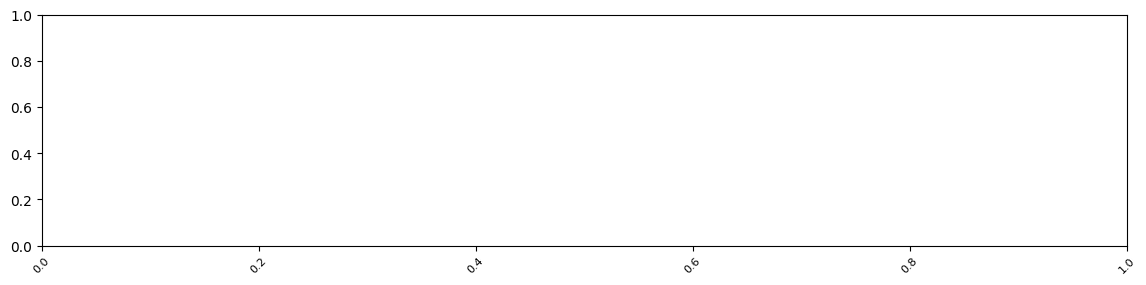

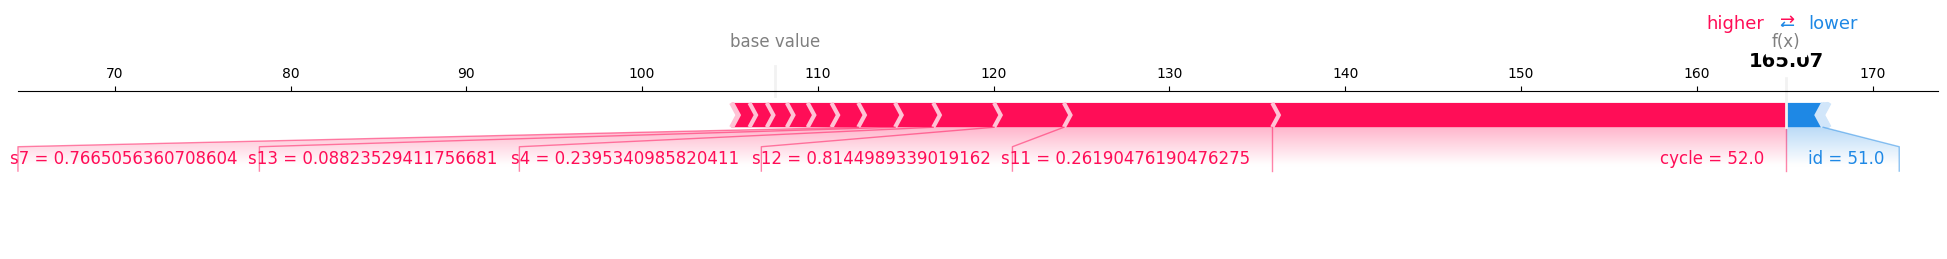

Plotting SHAP summary (Ensemble)...


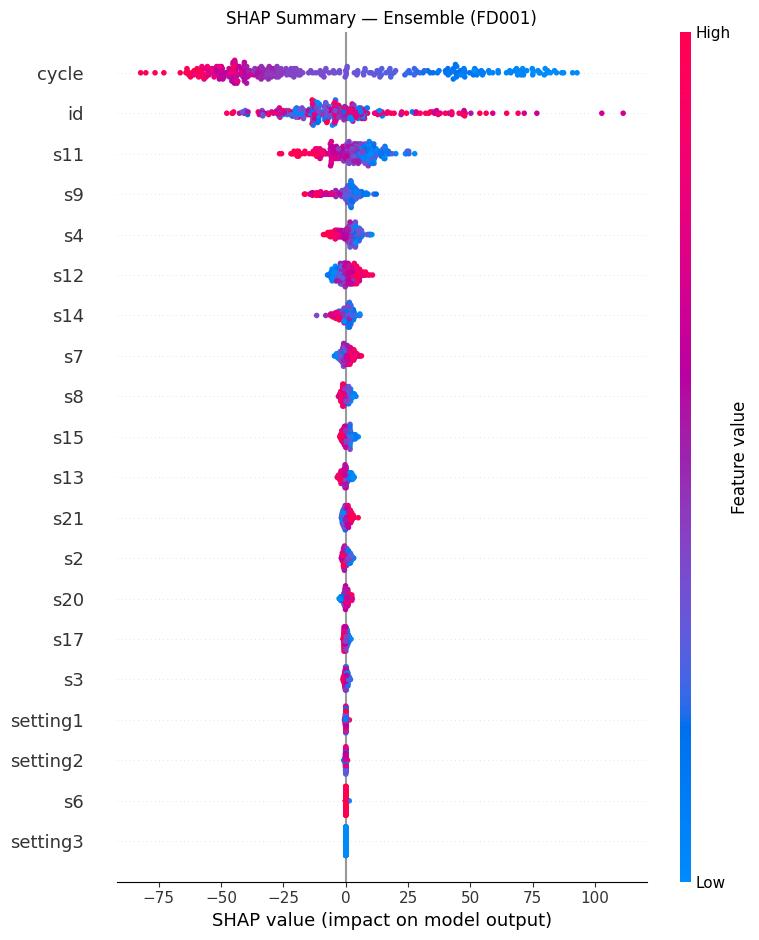

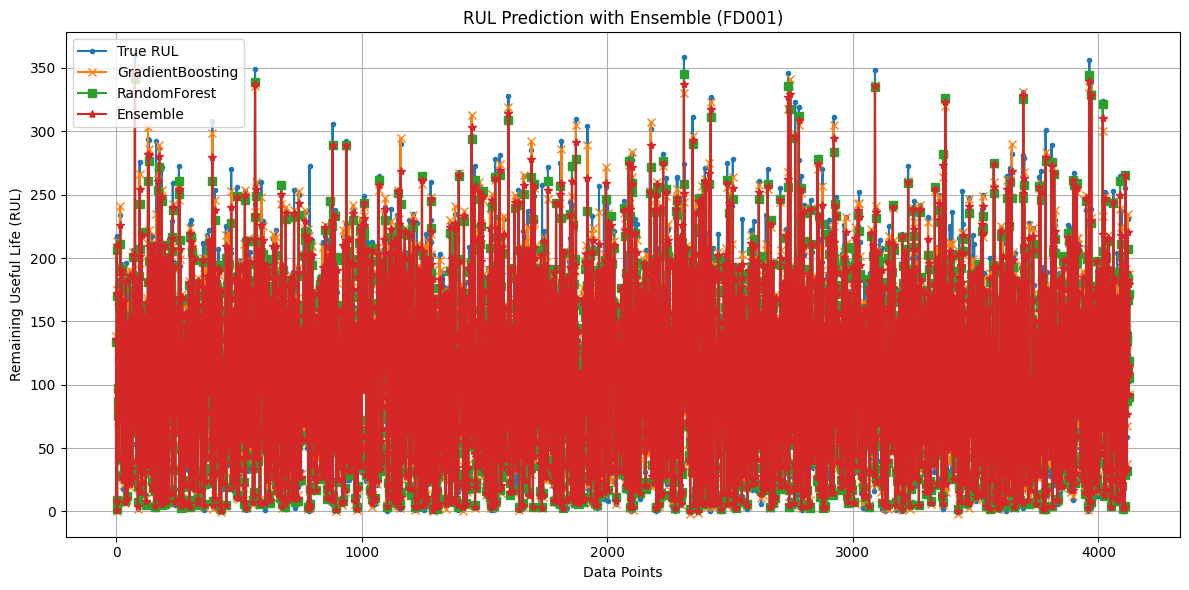



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (GradientBoosting) ---
Fold1: R2=0.3260, RMSE=58.1191, MAE=37.5161, PHM08_sum=5921858670.9111, PHM08_avg=1437344.3376
Fold2: R2=0.4819, RMSE=49.8601, MAE=31.7304, PHM08_sum=226210958.0435, PHM08_avg=54732.8715
Fold3: R2=0.4665, RMSE=50.3603, MAE=34.4495, PHM08_sum=109229746.6869, PHM08_avg=26473.5208
Fold4: R2=0.5243, RMSE=46.8672, MAE=33.6587, PHM08_sum=74841081.5846, PHM08_avg=18143.2925
Fold5: R2=0.2820, RMSE=57.0884, MAE=39.4434, PHM08_sum=353689689843.0342, PHM08_avg=85701402.9181
Overall: R2=0.4160, RMSE=52.6394, MAE=35.3580, PHM08_sum=360021830300.2603, PHM08_avg=17450527.3763

--- GroupKFold (RandomForest) ---
Fold1: R2=0.4461, RMSE=52.6868, MAE=33.7404, PHM08_sum=2634795817.2240, PHM08_avg=639513.5479
Fold2: R2=0.5630, RMSE=45.7910, MAE=29.3553

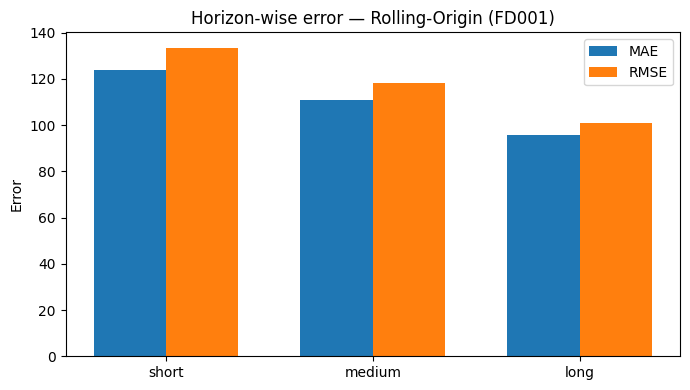

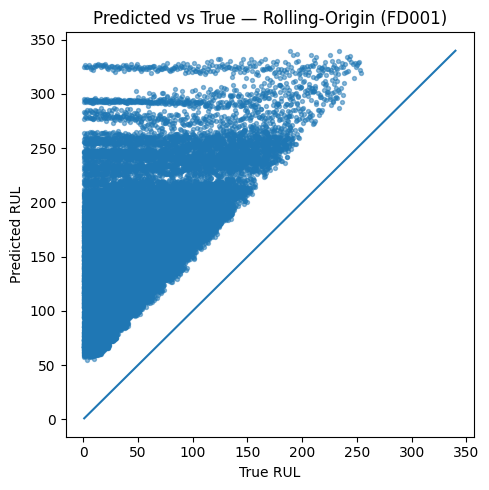


[PER-ENGINE MAE] (Top 10 worst engines)
69    166.064776
92    152.388810
96    151.587996
67    149.297581
83    139.058388
86    136.781679
2     135.893043
56    135.425781
64    134.537736
95    134.224402
dtype: float64


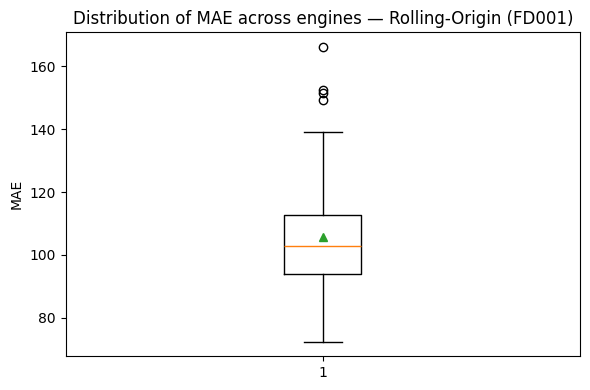

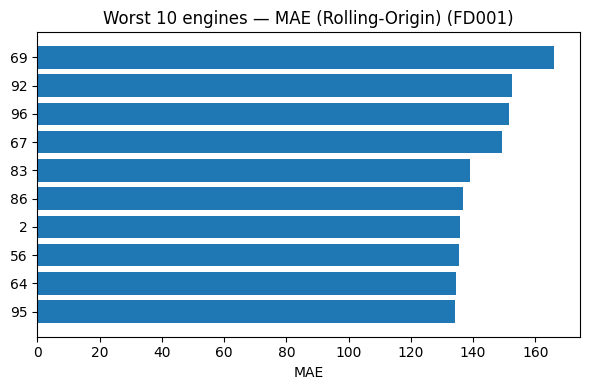


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -7.3138
    RMSE: 119.2421
     MAE: 110.9394
 sMAPE_%: 112.0829

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.4824 ± 0.0925
Without id/cycle : R²=0.6185 ± 0.0486


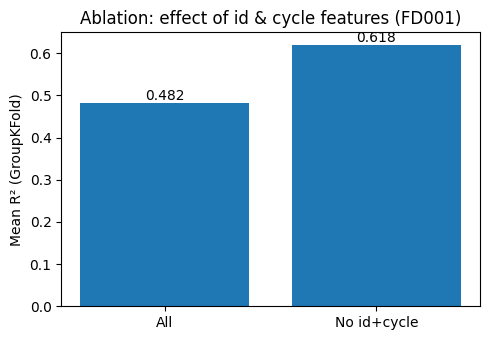


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 20631
Train (80%)   : 16504  → ratio=0.8000
Test  (20%)   : 4127  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 1159.02 seconds
CPU% at start        : 11.2%   (~0.29 GHz)
CPU% at end          : 22.7%   (~0.59 GHz)
Memory at start      : 288.68 MB
Memory at end        : 771.06 MB   (Δ 482.39 MB)


In [1]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD001"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "gbrf"

# Fixed model hyperparameters (as requested)
GB_PARAMS = dict(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)

RF_PARAMS = dict(
    n_estimators=100,
    max_depth=14,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ============================================
# Model training (GB + RF)
# ============================================
gb_model = GradientBoostingRegressor(**GB_PARAMS)
gb_model.fit(X_train, y_train)
y_gb = gb_model.predict(X_val)

rf_model = RandomForestRegressor(**RF_PARAMS)
rf_model.fit(X_train, y_train)
y_rf = rf_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_gb + 0.5 * y_rf

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_gb = print_block_metrics("GradientBoosting", y_val, y_gb)
m_rf = print_block_metrics("RandomForest",    y_val, y_rf)
m_ens= print_block_metrics("Ensemble",        y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_gb, m_rf, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations (TreeExplainer for tree models)
# ============================================
SHAP_SAMPLES = min(300, X_val.shape[0])  # small subset for speed
X_shap = X_val.sample(n=SHAP_SAMPLES, random_state=42)

def tree_shap_fast(model, X_explain_df, title_prefix, file_tag):
    # Fast TreeExplainer settings for tree models
    explainer = shap.TreeExplainer(
        model,
        feature_perturbation="tree_path_dependent",
        model_output="raw"
    )
    # Skip additivity check for speed; safe for visualization
    shap_vals = explainer.shap_values(X_explain_df, check_additivity=False)

    # Summary plot (saved)
    shap.summary_plot(shap_vals, X_explain_df, show=False)
    plt.title(f"SHAP Summary — {title_prefix} ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"SHAP_Summary_{file_tag}_{DATASET_NAME}.png")
    plt.show()

    # Single-row force plot (saved)
    row = X_explain_df.iloc[[0]]
    sv_row = np.asarray(explainer.shap_values(row, check_additivity=False))[0]
    expected_val = float(np.asarray(explainer.expected_value).mean())
    fig, ax = plt.subplots(figsize=(14, 3))
    _ = shap.force_plot(expected_val, sv_row, row.iloc[0].values,
                        feature_names=row.columns.tolist(), matplotlib=True, show=False)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    plt.tight_layout()
    save_png(f"Local_SHAP_force_{file_tag}_Single_{DATASET_NAME}.png")
    plt.show()

    return shap_vals

print("Computing SHAP (fast) for GradientBoosting...")
shap_vals_gb = tree_shap_fast(gb_model, X_shap, "GradientBoosting", "GradientBoosting")

print("Computing SHAP (fast) for RandomForest...")
shap_vals_rf = tree_shap_fast(rf_model, X_shap, "RandomForest", "RandomForest")

# Ensemble SHAP (only if shapes match)
if np.shape(shap_vals_gb) == np.shape(shap_vals_rf):
    shap_vals_ens = (np.asarray(shap_vals_gb) + np.asarray(shap_vals_rf)) / 2.0
    print("Plotting SHAP summary (Ensemble)...")
    shap.summary_plot(shap_vals_ens, X_shap, show=False)
    plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] Ensemble SHAP skipped (shape mismatch).")

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_gb)),       y_gb,           label="GradientBoosting",  marker='x')
plt.plot(range(len(y_rf)),       y_rf,           label="RandomForest",      marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",          marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

import warnings
warnings.filterwarnings("ignore")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_gb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", GradientBoostingRegressor(**GB_PARAMS))
])
pipe_rf = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", RandomForestRegressor(**RF_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_gb, name="GradientBoosting")
_ = cv_eval_pipeline(X, y, groups, pipe_rf, name="RandomForest")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_gb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", GradientBoostingRegressor(**GB_PARAMS))
    ])

def build_pipe_rf():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_gb, name="GradientBoosting"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf, name="RandomForest"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    # For tree models, scaling is usually irrelevant; still keep for symmetry/leakage demo
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_rf, name="RandomForest")
_ = cv_eval_pipeline(X, y, groups, build_pipe_rf(), name="RandomForest (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf,
    embargo_val=0,  name=f"Rolling-Origin RF (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf,
    embargo_val=10, name=f"Rolling-Origin RF (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_rf)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_rf)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")



GradientBoosting Performance:
  R^2 Score:           0.9804
  Mean Squared Error:  91.7819
  Mean Absolute Error: 7.3138
  PHM08 Score (sum):   15072.2448
  PHM08 Score (avg):   1.4018

RandomForest Performance:
  R^2 Score:           0.8648
  Mean Squared Error:  634.4342
  Mean Absolute Error: 17.8286
  PHM08 Score (sum):   2144344.3468
  PHM08 Score (avg):   199.4368

Ensemble Performance:
  R^2 Score:           0.9433
  Mean Squared Error:  266.1113
  Mean Absolute Error: 11.9198
  PHM08 Score (sum):   84822.6494
  PHM08 Score (avg):   7.8890
Computing SHAP (fast) for GradientBoosting...


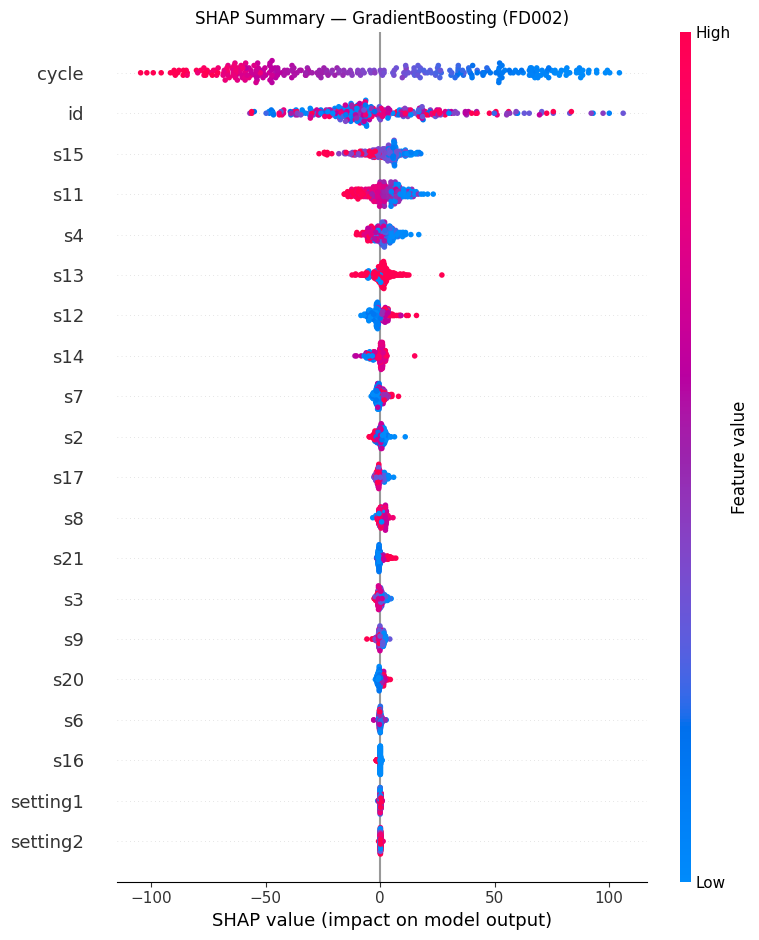

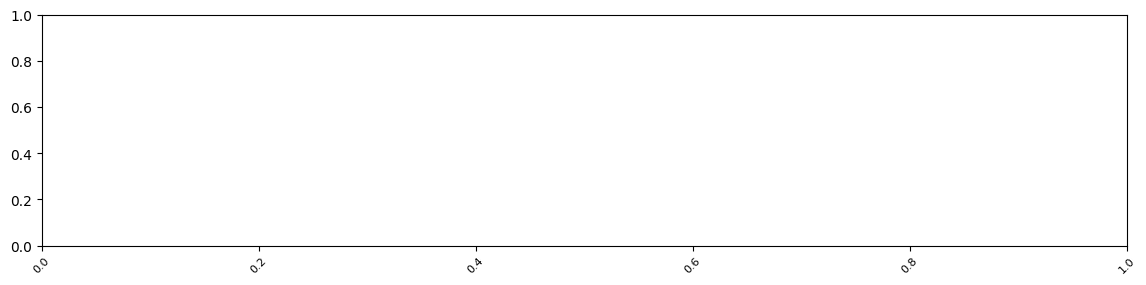

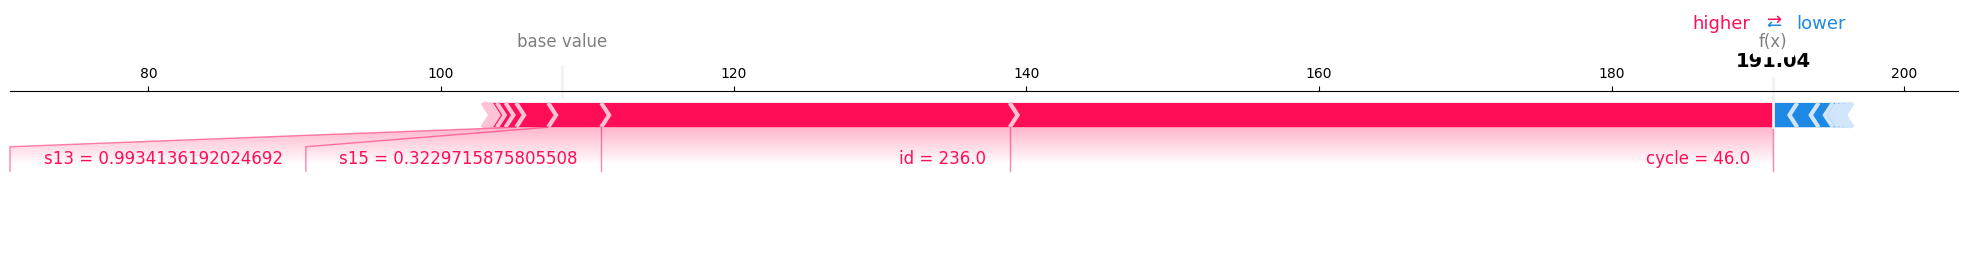

Computing SHAP (fast) for RandomForest...


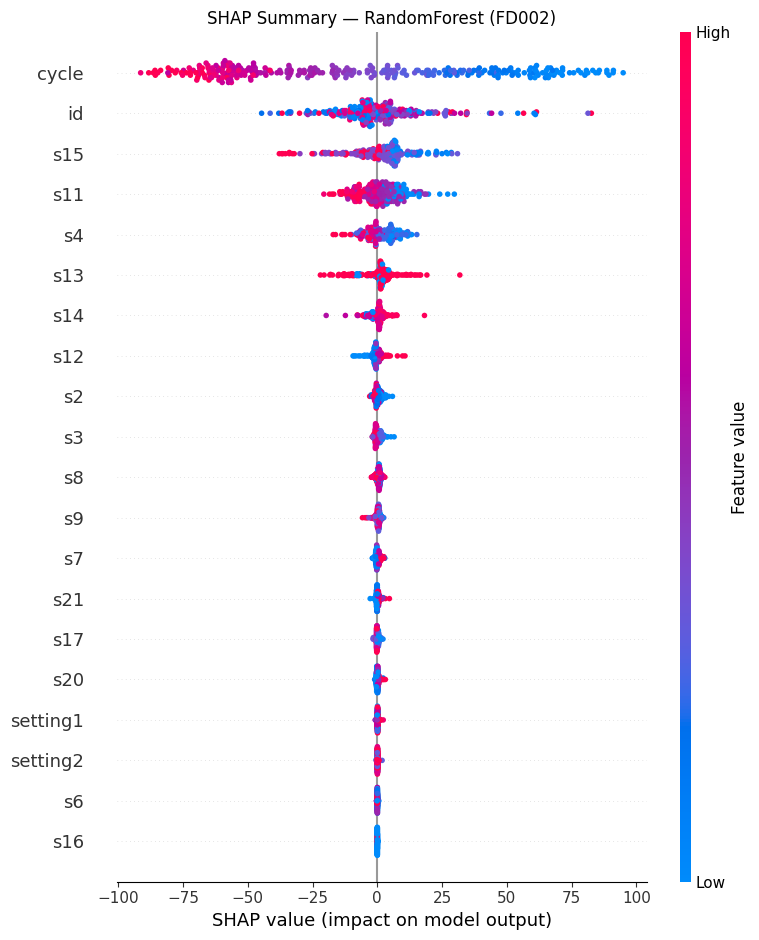

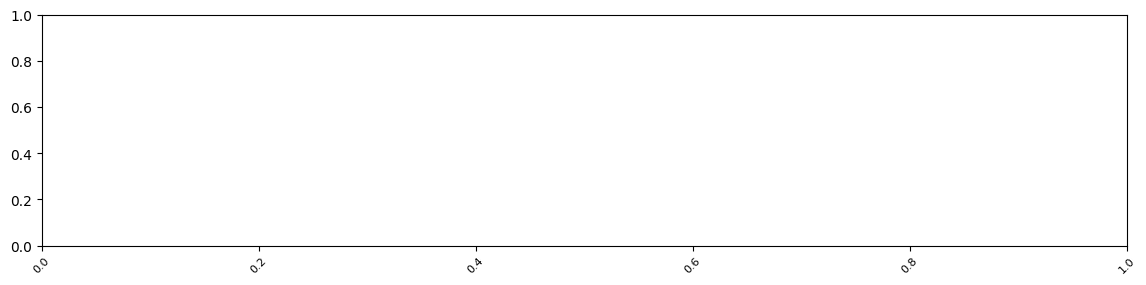

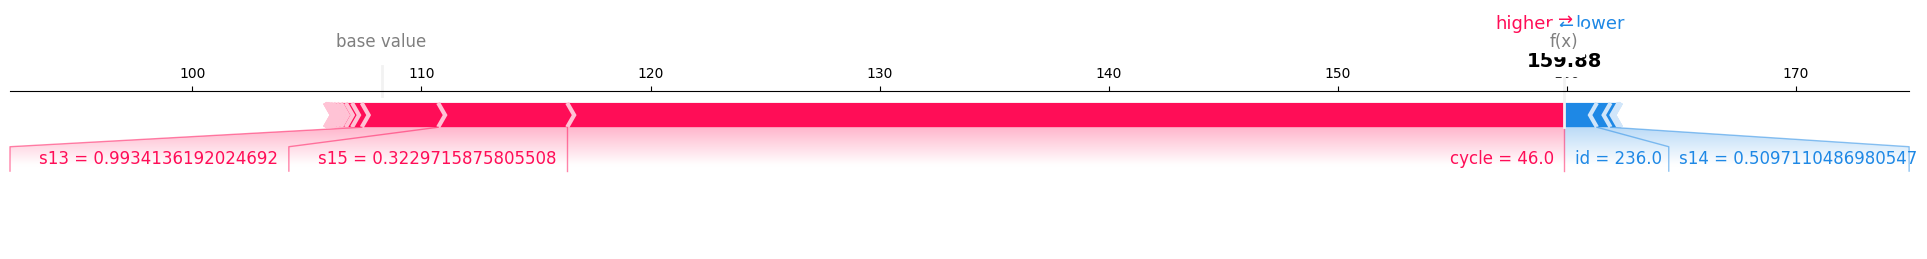

Plotting SHAP summary (Ensemble)...


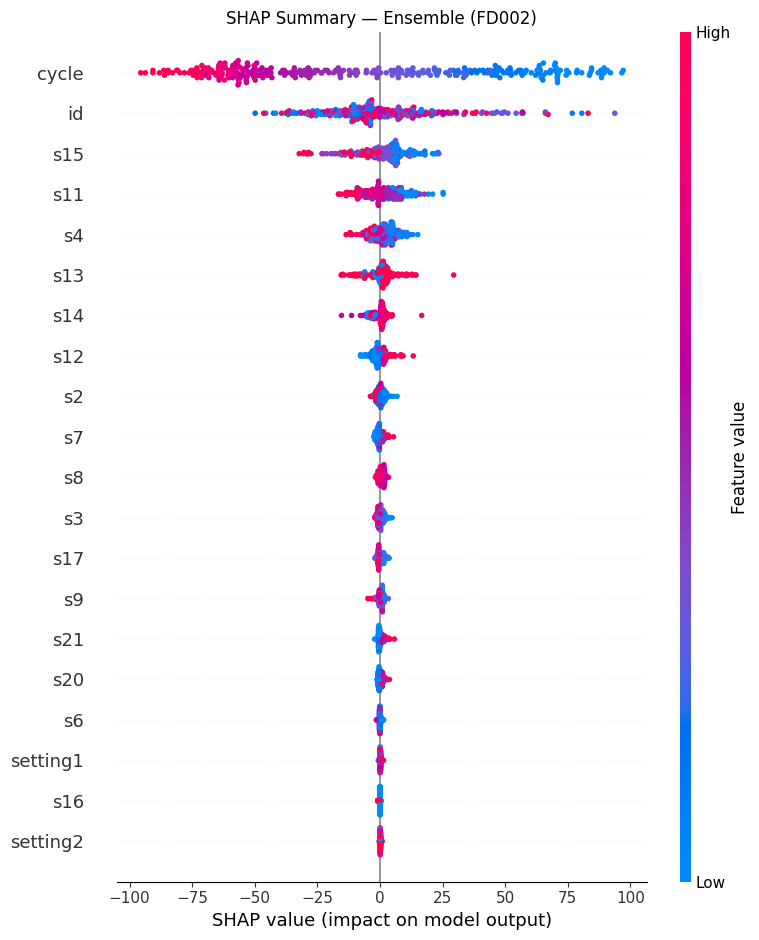

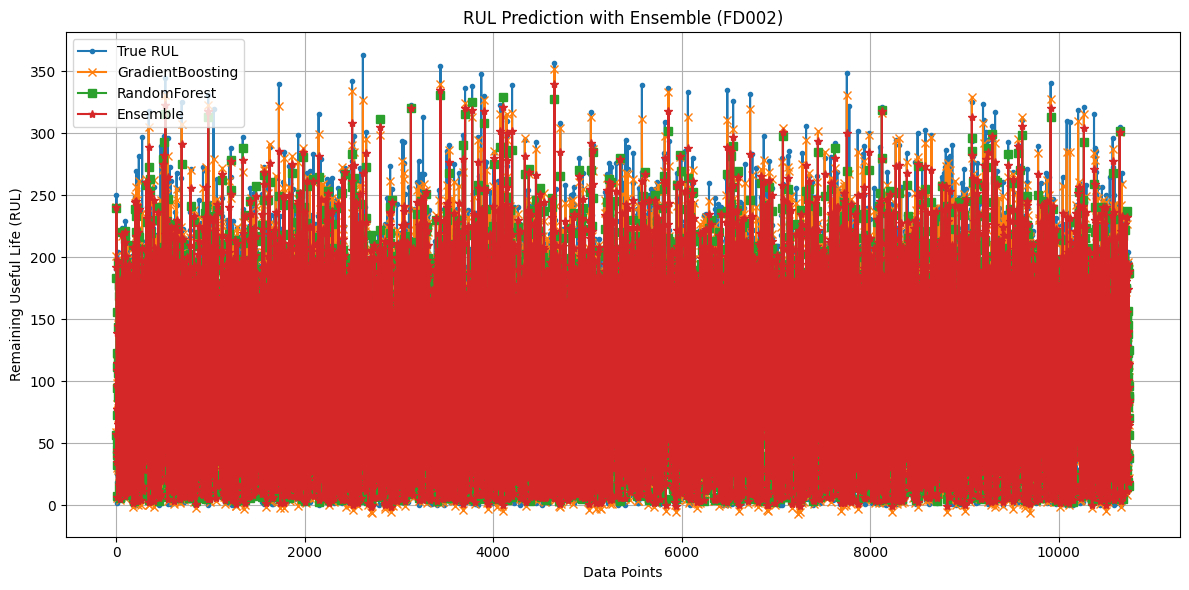



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (GradientBoosting) ---
Fold1: R2=0.4686, RMSE=50.7300, MAE=39.2821, PHM08_sum=59023410.6269, PHM08_avg=5487.9973
Fold2: R2=0.4299, RMSE=52.3238, MAE=38.4324, PHM08_sum=2977408866.7118, PHM08_avg=276994.0336
Fold3: R2=0.6190, RMSE=42.5371, MAE=30.6247, PHM08_sum=10420539.0977, PHM08_avg=969.0820
Fold4: R2=0.4985, RMSE=48.8023, MAE=37.1777, PHM08_sum=63885510.0112, PHM08_avg=5941.1801
Fold5: R2=0.5535, RMSE=46.2259, MAE=33.6986, PHM08_sum=140416524.9083, PHM08_avg=13063.2175
Overall: R2=0.5136, RMSE=48.2477, MAE=35.8432, PHM08_sum=3251154851.3558, PHM08_avg=60476.4756

--- GroupKFold (RandomForest) ---
Fold1: R2=0.5761, RMSE=45.3095, MAE=32.1935, PHM08_sum=69609955.4799, PHM08_avg=6472.3343
Fold2: R2=0.5602, RMSE=45.9538, MAE=31.5927, PHM08_sum=4586858809

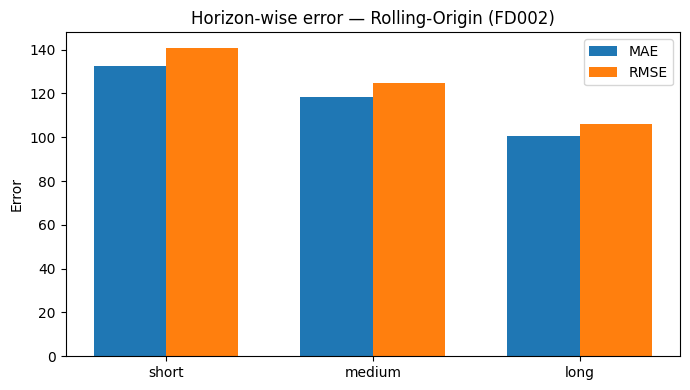

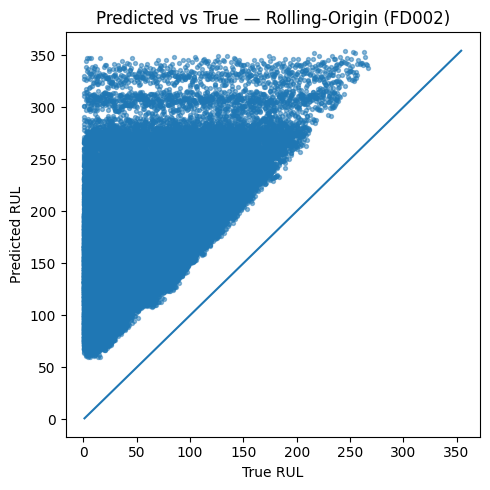


[PER-ENGINE MAE] (Top 10 worst engines)
112    179.495590
85     174.054767
88     173.210827
255    169.977568
118    164.668303
31     163.339924
158    153.200360
135    150.375370
156    149.401262
260    149.233293
dtype: float64


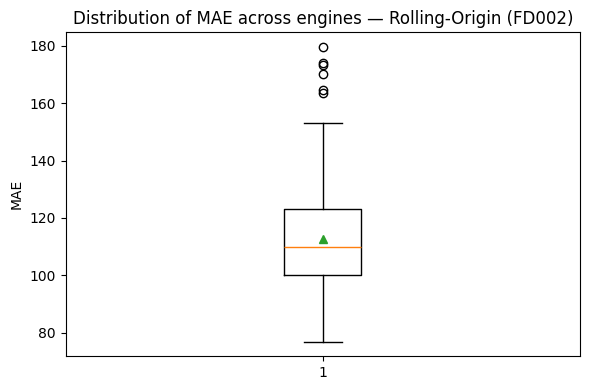

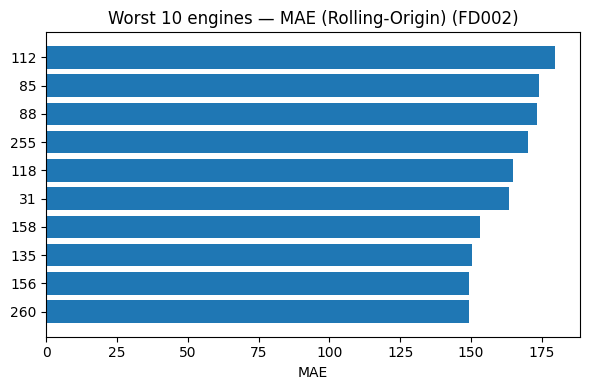


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -8.1336
    RMSE: 125.6355
     MAE: 118.0938
 sMAPE_%: 114.8889

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.6128 ± 0.0380
Without id/cycle : R²=0.5951 ± 0.0285


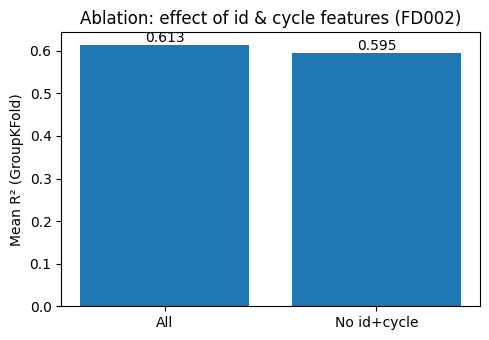


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 53759
Train (80%)   : 43007  → ratio=0.8000
Test  (20%)   : 10752  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 3059.53 seconds
CPU% at start        : 4.2%   (~0.11 GHz)
CPU% at end          : 21.5%   (~0.56 GHz)
Memory at start      : 771.06 MB
Memory at end        : 1003.66 MB   (Δ 232.59 MB)


In [2]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD002"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "gbrf"

# Fixed model hyperparameters (as requested)
GB_PARAMS = dict(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)

RF_PARAMS = dict(
    n_estimators=100,
    max_depth=14,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ============================================
# Model training (GB + RF)
# ============================================
gb_model = GradientBoostingRegressor(**GB_PARAMS)
gb_model.fit(X_train, y_train)
y_gb = gb_model.predict(X_val)

rf_model = RandomForestRegressor(**RF_PARAMS)
rf_model.fit(X_train, y_train)
y_rf = rf_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_gb + 0.5 * y_rf

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_gb = print_block_metrics("GradientBoosting", y_val, y_gb)
m_rf = print_block_metrics("RandomForest",    y_val, y_rf)
m_ens= print_block_metrics("Ensemble",        y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_gb, m_rf, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations (TreeExplainer for tree models)
# ============================================
SHAP_SAMPLES = min(300, X_val.shape[0])  # small subset for speed
X_shap = X_val.sample(n=SHAP_SAMPLES, random_state=42)

def tree_shap_fast(model, X_explain_df, title_prefix, file_tag):
    # Fast TreeExplainer settings for tree models
    explainer = shap.TreeExplainer(
        model,
        feature_perturbation="tree_path_dependent",
        model_output="raw"
    )
    # Skip additivity check for speed; safe for visualization
    shap_vals = explainer.shap_values(X_explain_df, check_additivity=False)

    # Summary plot (saved)
    shap.summary_plot(shap_vals, X_explain_df, show=False)
    plt.title(f"SHAP Summary — {title_prefix} ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"SHAP_Summary_{file_tag}_{DATASET_NAME}.png")
    plt.show()

    # Single-row force plot (saved)
    row = X_explain_df.iloc[[0]]
    sv_row = np.asarray(explainer.shap_values(row, check_additivity=False))[0]
    expected_val = float(np.asarray(explainer.expected_value).mean())
    fig, ax = plt.subplots(figsize=(14, 3))
    _ = shap.force_plot(expected_val, sv_row, row.iloc[0].values,
                        feature_names=row.columns.tolist(), matplotlib=True, show=False)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    plt.tight_layout()
    save_png(f"Local_SHAP_force_{file_tag}_Single_{DATASET_NAME}.png")
    plt.show()

    return shap_vals

print("Computing SHAP (fast) for GradientBoosting...")
shap_vals_gb = tree_shap_fast(gb_model, X_shap, "GradientBoosting", "GradientBoosting")

print("Computing SHAP (fast) for RandomForest...")
shap_vals_rf = tree_shap_fast(rf_model, X_shap, "RandomForest", "RandomForest")

# Ensemble SHAP (only if shapes match)
if np.shape(shap_vals_gb) == np.shape(shap_vals_rf):
    shap_vals_ens = (np.asarray(shap_vals_gb) + np.asarray(shap_vals_rf)) / 2.0
    print("Plotting SHAP summary (Ensemble)...")
    shap.summary_plot(shap_vals_ens, X_shap, show=False)
    plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] Ensemble SHAP skipped (shape mismatch).")

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_gb)),       y_gb,           label="GradientBoosting",  marker='x')
plt.plot(range(len(y_rf)),       y_rf,           label="RandomForest",      marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",          marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

import warnings
warnings.filterwarnings("ignore")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_gb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", GradientBoostingRegressor(**GB_PARAMS))
])
pipe_rf = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", RandomForestRegressor(**RF_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_gb, name="GradientBoosting")
_ = cv_eval_pipeline(X, y, groups, pipe_rf, name="RandomForest")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_gb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", GradientBoostingRegressor(**GB_PARAMS))
    ])

def build_pipe_rf():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_gb, name="GradientBoosting"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf, name="RandomForest"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    # For tree models, scaling is usually irrelevant; still keep for symmetry/leakage demo
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_rf, name="RandomForest")
_ = cv_eval_pipeline(X, y, groups, build_pipe_rf(), name="RandomForest (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf,
    embargo_val=0,  name=f"Rolling-Origin RF (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf,
    embargo_val=10, name=f"Rolling-Origin RF (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_rf)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_rf)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")



GradientBoosting Performance:
  R^2 Score:           0.9866
  Mean Squared Error:  130.9718
  Mean Absolute Error: 7.8019
  PHM08 Score (sum):   28202.9870
  PHM08 Score (avg):   5.7045

RandomForest Performance:
  R^2 Score:           0.9696
  Mean Squared Error:  298.2327
  Mean Absolute Error: 10.8784
  PHM08 Score (sum):   3361325.5248
  PHM08 Score (avg):   679.8798

Ensemble Performance:
  R^2 Score:           0.9833
  Mean Squared Error:  163.6578
  Mean Absolute Error: 8.4327
  PHM08 Score (sum):   123464.7088
  PHM08 Score (avg):   24.9726
Computing SHAP (fast) for GradientBoosting...


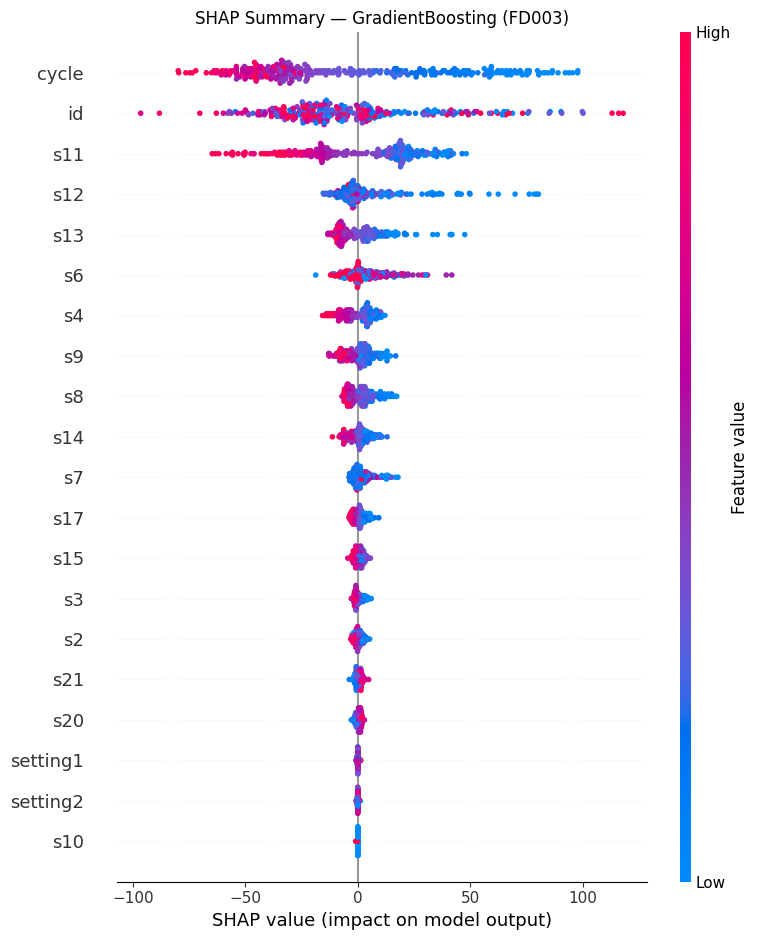

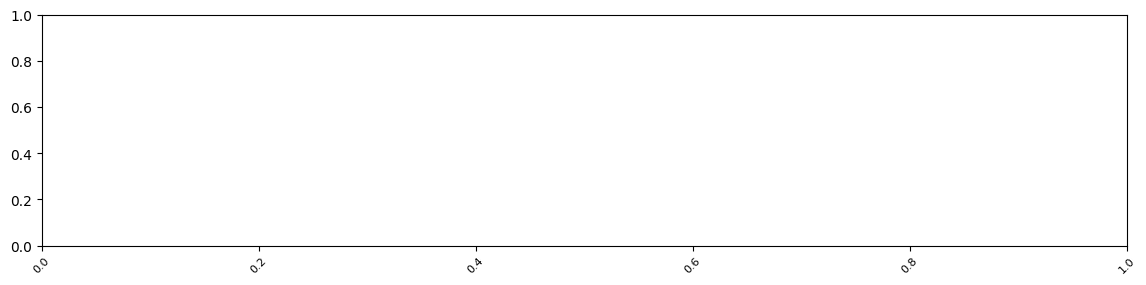

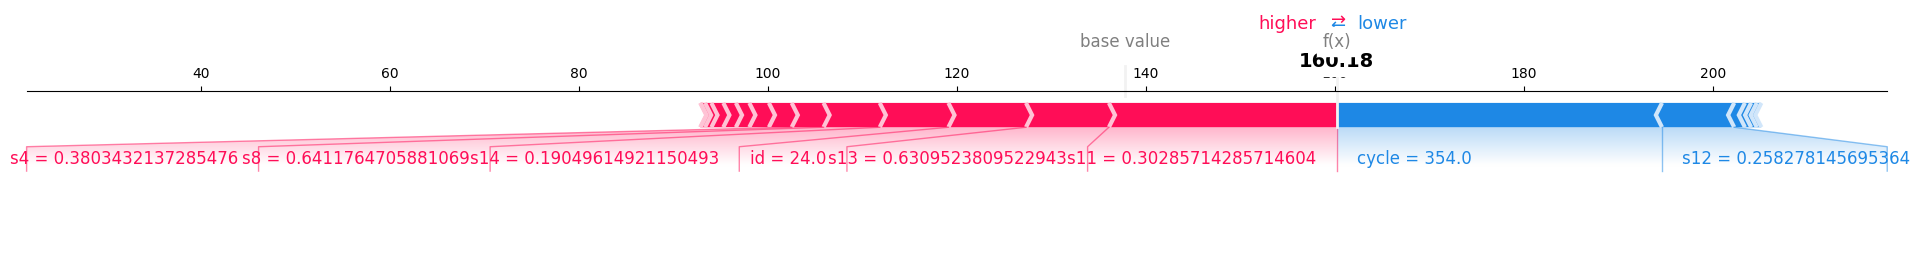

Computing SHAP (fast) for RandomForest...


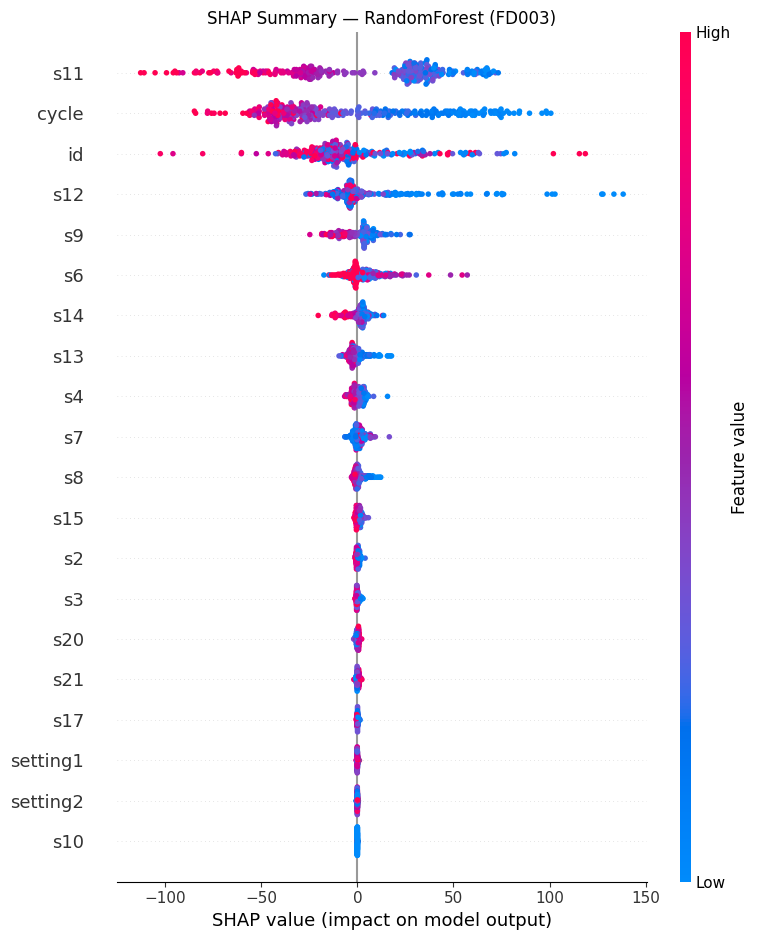

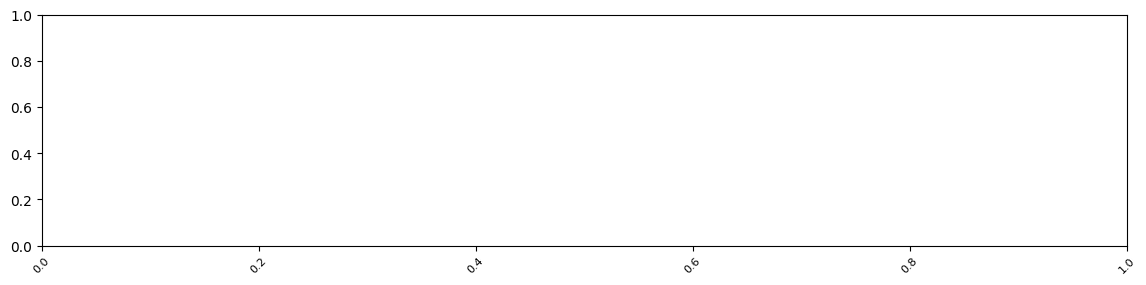

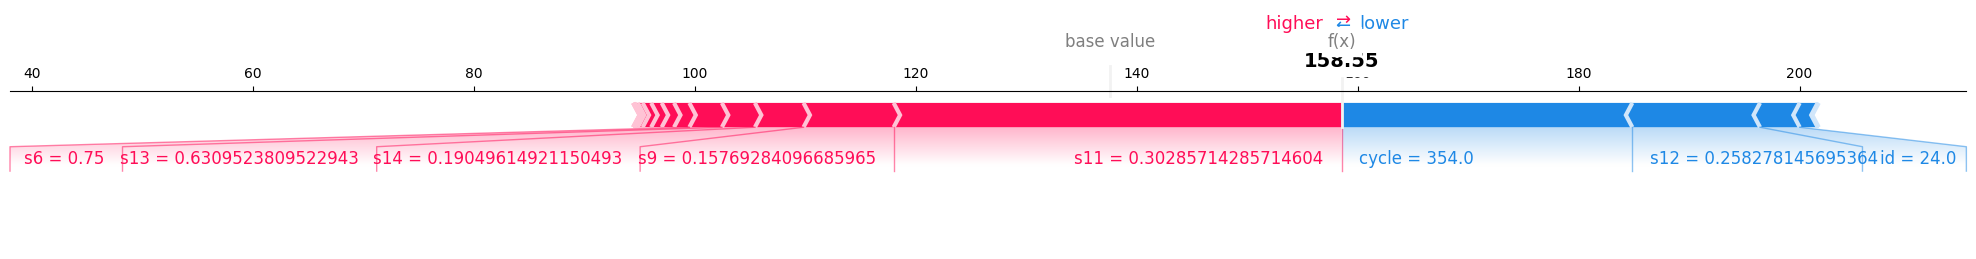

Plotting SHAP summary (Ensemble)...


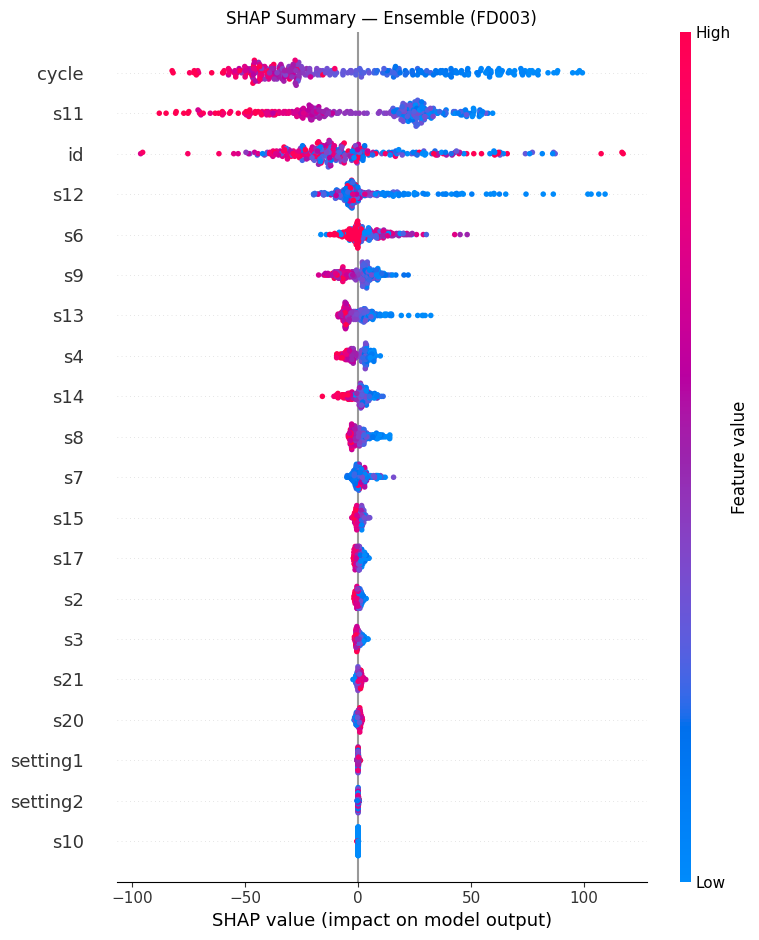

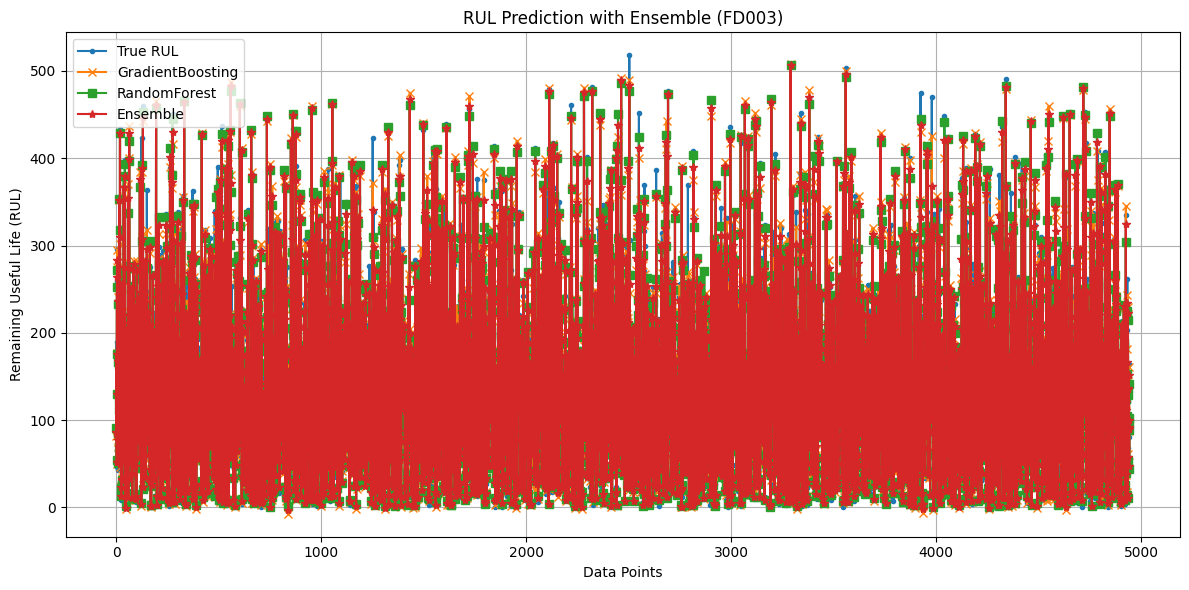



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (GradientBoosting) ---
Fold1: R2=0.2794, RMSE=86.0005, MAE=54.6742, PHM08_sum=3497041086463.8252, PHM08_avg=707616569.4990
Fold2: R2=0.5687, RMSE=64.7876, MAE=44.4106, PHM08_sum=6945692459.6020, PHM08_avg=1404304.9858
Fold3: R2=0.3020, RMSE=82.1653, MAE=56.9194, PHM08_sum=61303602118618.6484, PHM08_avg=12394581908.3337
Fold4: R2=0.2311, RMSE=86.0618, MAE=53.8653, PHM08_sum=641310511909.0068, PHM08_avg=129819941.6820
Fold5: R2=0.4235, RMSE=74.2003, MAE=52.7491, PHM08_sum=6404265352.0855, PHM08_avg=1294837.3134
Overall: R2=0.3602, RMSE=79.0628, MAE=52.5230, PHM08_sum=65455303674803.1719, PHM08_avg=2647868271.6344

--- GroupKFold (RandomForest) ---
Fold1: R2=0.2391, RMSE=88.3719, MAE=53.8392, PHM08_sum=10944905540734.5352, PHM08_avg=2214671295.1709
Fold2: 

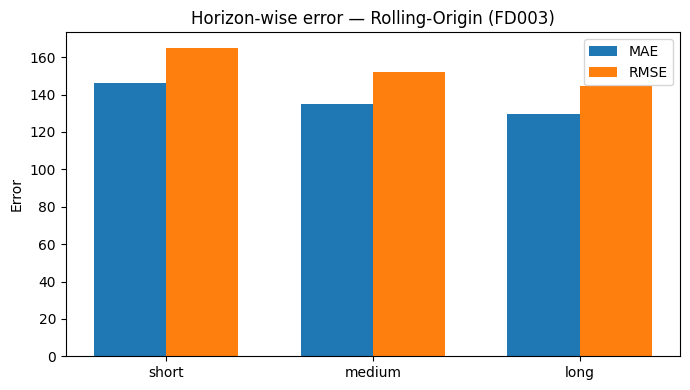

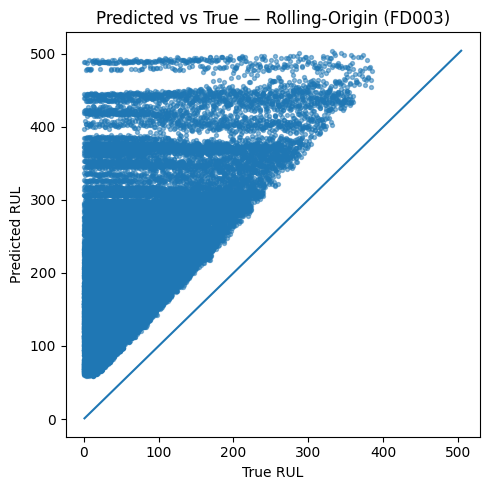


[PER-ENGINE MAE] (Top 10 worst engines)
55    225.334291
24    212.009150
96    209.820557
10    205.564070
34    202.119989
18    198.621299
9     185.716875
7     183.756038
71    180.987849
94    168.035456
dtype: float64


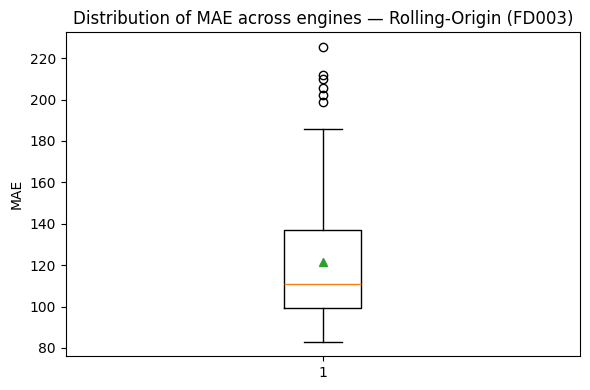

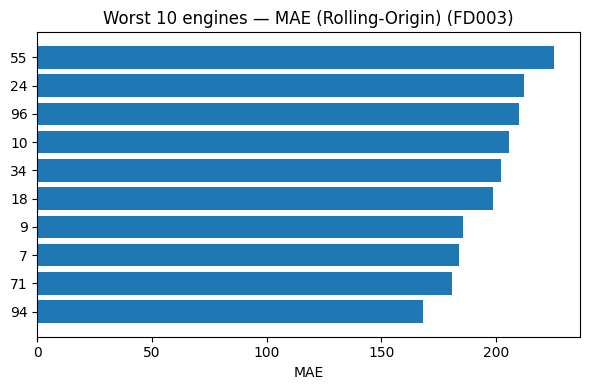


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -4.9053
    RMSE: 152.7919
     MAE: 135.6704
 sMAPE_%: 107.6936

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.3803 ± 0.1310
Without id/cycle : R²=0.5673 ± 0.0880


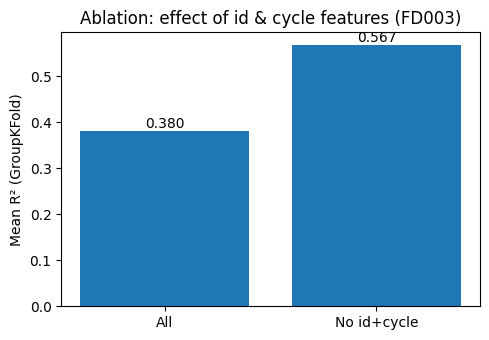


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 24720
Train (80%)   : 19776  → ratio=0.8000
Test  (20%)   : 4944  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 1229.44 seconds
CPU% at start        : 13.5%   (~0.35 GHz)
CPU% at end          : 22.5%   (~0.58 GHz)
Memory at start      : 1003.91 MB
Memory at end        : 1091.43 MB   (Δ 87.52 MB)


In [3]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD003"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "gbrf"

# Fixed model hyperparameters (as requested)
GB_PARAMS = dict(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)

RF_PARAMS = dict(
    n_estimators=100,
    max_depth=14,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ============================================
# Model training (GB + RF)
# ============================================
gb_model = GradientBoostingRegressor(**GB_PARAMS)
gb_model.fit(X_train, y_train)
y_gb = gb_model.predict(X_val)

rf_model = RandomForestRegressor(**RF_PARAMS)
rf_model.fit(X_train, y_train)
y_rf = rf_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_gb + 0.5 * y_rf

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_gb = print_block_metrics("GradientBoosting", y_val, y_gb)
m_rf = print_block_metrics("RandomForest",    y_val, y_rf)
m_ens= print_block_metrics("Ensemble",        y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_gb, m_rf, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations (TreeExplainer for tree models)
# ============================================
SHAP_SAMPLES = min(300, X_val.shape[0])  # small subset for speed
X_shap = X_val.sample(n=SHAP_SAMPLES, random_state=42)

def tree_shap_fast(model, X_explain_df, title_prefix, file_tag):
    # Fast TreeExplainer settings for tree models
    explainer = shap.TreeExplainer(
        model,
        feature_perturbation="tree_path_dependent",
        model_output="raw"
    )
    # Skip additivity check for speed; safe for visualization
    shap_vals = explainer.shap_values(X_explain_df, check_additivity=False)

    # Summary plot (saved)
    shap.summary_plot(shap_vals, X_explain_df, show=False)
    plt.title(f"SHAP Summary — {title_prefix} ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"SHAP_Summary_{file_tag}_{DATASET_NAME}.png")
    plt.show()

    # Single-row force plot (saved)
    row = X_explain_df.iloc[[0]]
    sv_row = np.asarray(explainer.shap_values(row, check_additivity=False))[0]
    expected_val = float(np.asarray(explainer.expected_value).mean())
    fig, ax = plt.subplots(figsize=(14, 3))
    _ = shap.force_plot(expected_val, sv_row, row.iloc[0].values,
                        feature_names=row.columns.tolist(), matplotlib=True, show=False)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    plt.tight_layout()
    save_png(f"Local_SHAP_force_{file_tag}_Single_{DATASET_NAME}.png")
    plt.show()

    return shap_vals

print("Computing SHAP (fast) for GradientBoosting...")
shap_vals_gb = tree_shap_fast(gb_model, X_shap, "GradientBoosting", "GradientBoosting")

print("Computing SHAP (fast) for RandomForest...")
shap_vals_rf = tree_shap_fast(rf_model, X_shap, "RandomForest", "RandomForest")

# Ensemble SHAP (only if shapes match)
if np.shape(shap_vals_gb) == np.shape(shap_vals_rf):
    shap_vals_ens = (np.asarray(shap_vals_gb) + np.asarray(shap_vals_rf)) / 2.0
    print("Plotting SHAP summary (Ensemble)...")
    shap.summary_plot(shap_vals_ens, X_shap, show=False)
    plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] Ensemble SHAP skipped (shape mismatch).")

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_gb)),       y_gb,           label="GradientBoosting",  marker='x')
plt.plot(range(len(y_rf)),       y_rf,           label="RandomForest",      marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",          marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

import warnings
warnings.filterwarnings("ignore")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_gb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", GradientBoostingRegressor(**GB_PARAMS))
])
pipe_rf = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", RandomForestRegressor(**RF_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_gb, name="GradientBoosting")
_ = cv_eval_pipeline(X, y, groups, pipe_rf, name="RandomForest")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_gb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", GradientBoostingRegressor(**GB_PARAMS))
    ])

def build_pipe_rf():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_gb, name="GradientBoosting"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf, name="RandomForest"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    # For tree models, scaling is usually irrelevant; still keep for symmetry/leakage demo
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_rf, name="RandomForest")
_ = cv_eval_pipeline(X, y, groups, build_pipe_rf(), name="RandomForest (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf,
    embargo_val=0,  name=f"Rolling-Origin RF (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf,
    embargo_val=10, name=f"Rolling-Origin RF (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_rf)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_rf)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")



GradientBoosting Performance:
  R^2 Score:           0.9779
  Mean Squared Error:  177.9456
  Mean Absolute Error: 10.0170
  PHM08 Score (sum):   38718.4295
  PHM08 Score (avg):   3.1607

RandomForest Performance:
  R^2 Score:           0.7783
  Mean Squared Error:  1782.6089
  Mean Absolute Error: 30.6537
  PHM08 Score (sum):   29022650227.0852
  PHM08 Score (avg):   2369195.9369

Ensemble Performance:
  R^2 Score:           0.9156
  Mean Squared Error:  678.7407
  Mean Absolute Error: 19.1853
  PHM08 Score (sum):   5165033.2493
  PHM08 Score (avg):   421.6354
Computing SHAP (fast) for GradientBoosting...


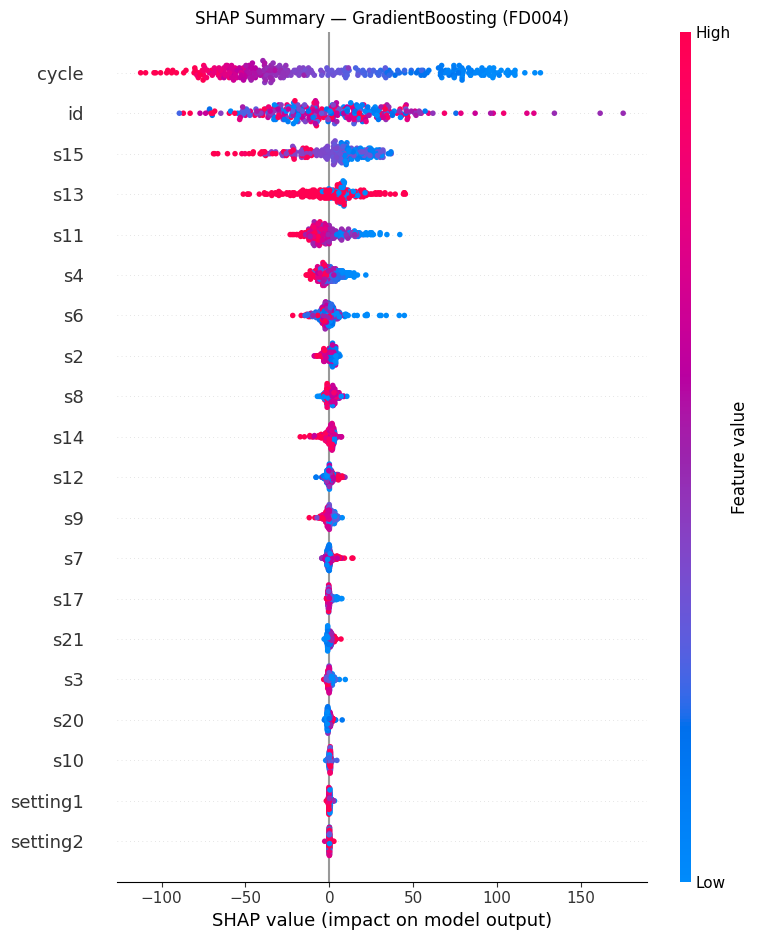

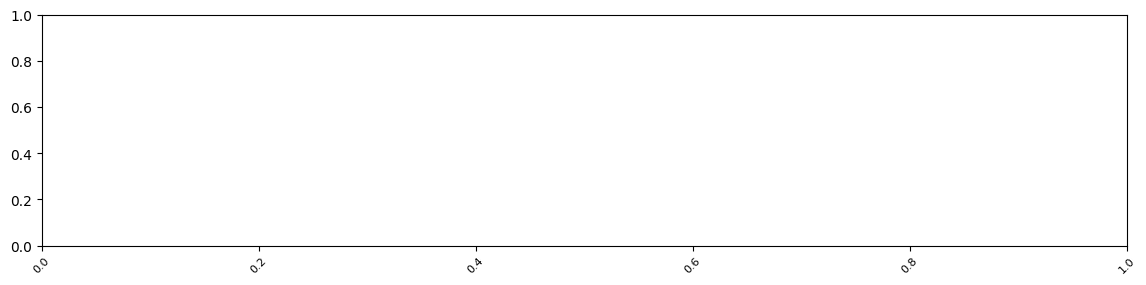

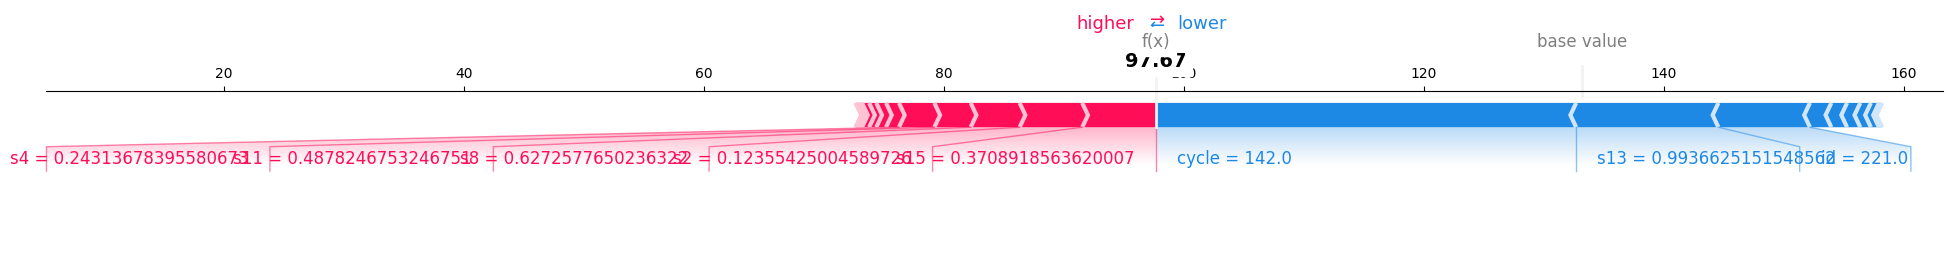

Computing SHAP (fast) for RandomForest...


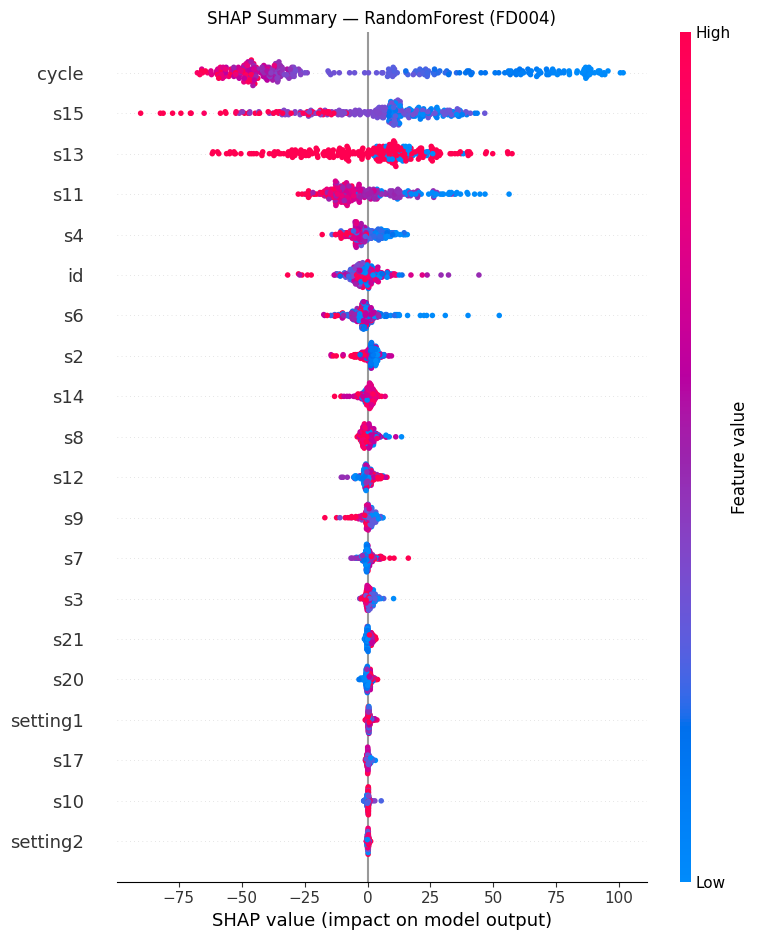

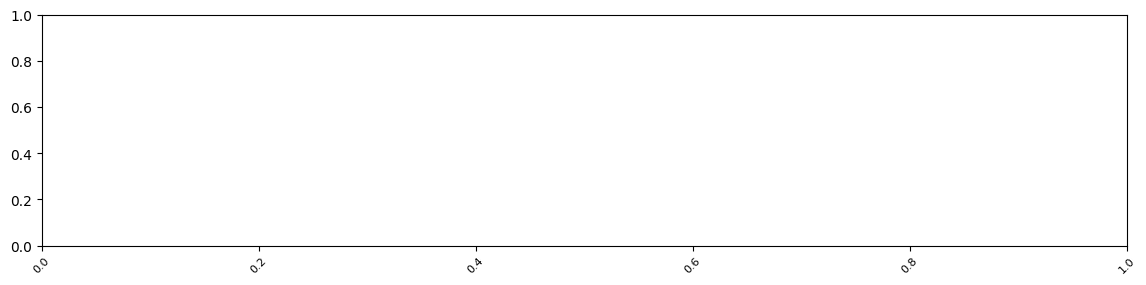

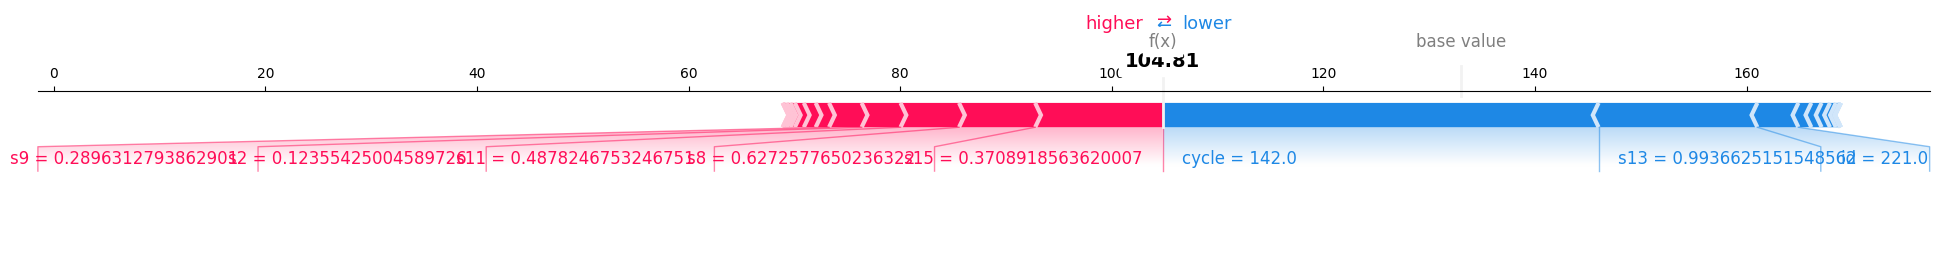

Plotting SHAP summary (Ensemble)...


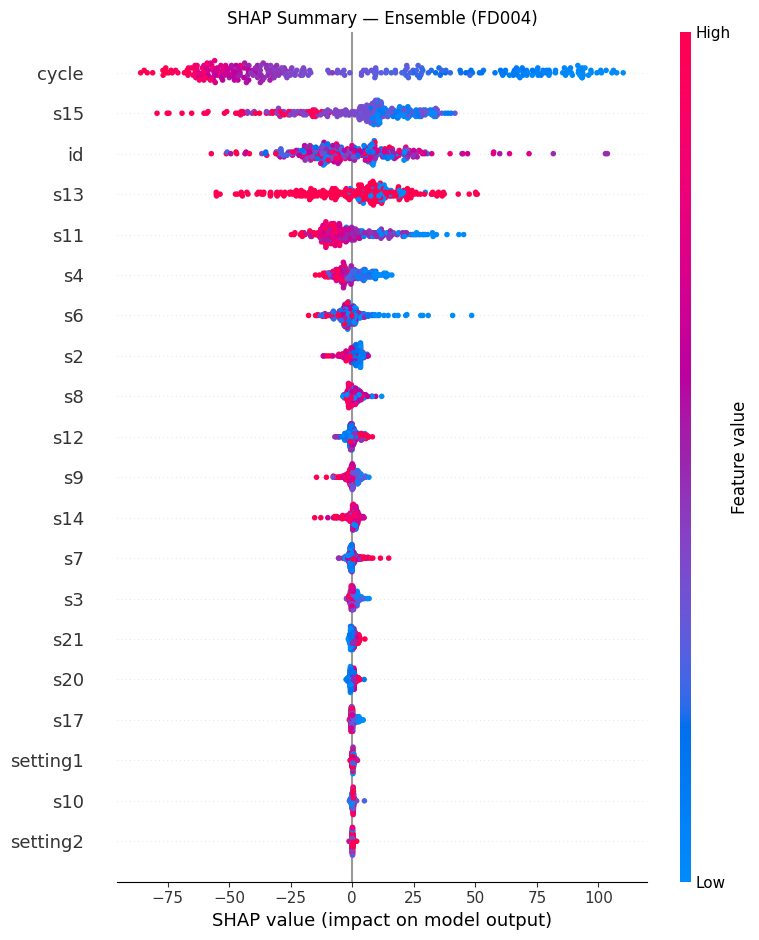

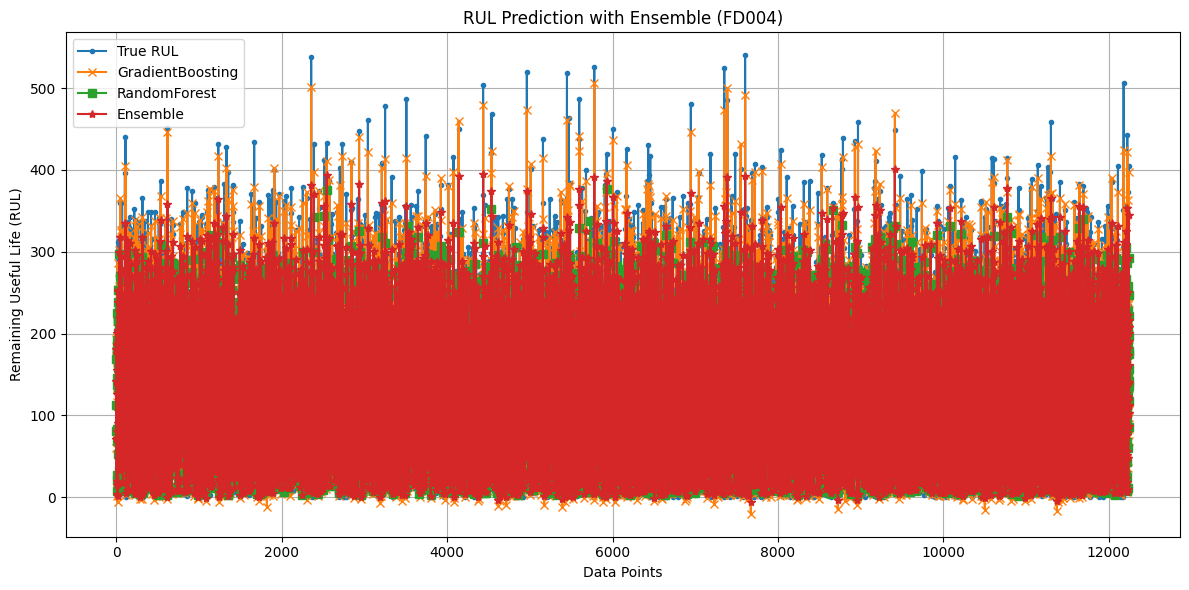



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (GradientBoosting) ---
Fold1: R2=0.3243, RMSE=76.2493, MAE=55.5649, PHM08_sum=32874043269.0920, PHM08_avg=2677039.3542
Fold2: R2=0.3185, RMSE=74.2292, MAE=52.4392, PHM08_sum=407813495092124.8125, PHM08_avg=33575950526.2741
Fold3: R2=0.5781, RMSE=57.7399, MAE=41.7918, PHM08_sum=4991167499.6352, PHM08_avg=406678.6849
Fold4: R2=0.5810, RMSE=57.3803, MAE=41.7893, PHM08_sum=37361412174.2758, PHM08_avg=3043947.5456
Fold5: R2=0.6162, RMSE=54.8982, MAE=41.0671, PHM08_sum=2302088001.7529, PHM08_avg=187527.5335
Overall: R2=0.4802, RMSE=64.7318, MAE=46.5189, PHM08_sum=407891023803069.5625, PHM08_avg=6659554013.9932

--- GroupKFold (RandomForest) ---
Fold1: R2=0.5050, RMSE=65.2622, MAE=44.9713, PHM08_sum=3972304932123.9971, PHM08_avg=323477600.3358
Fold2: R2=0.6760

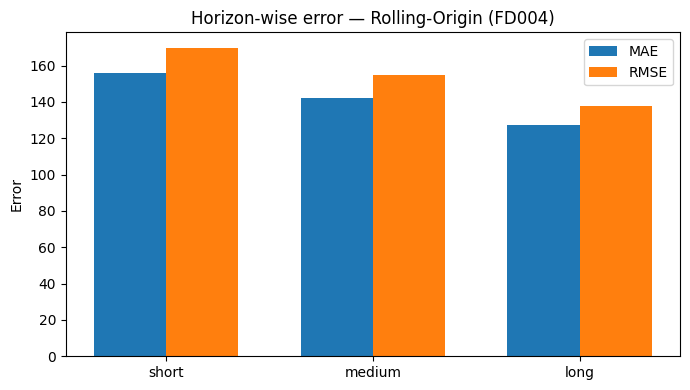

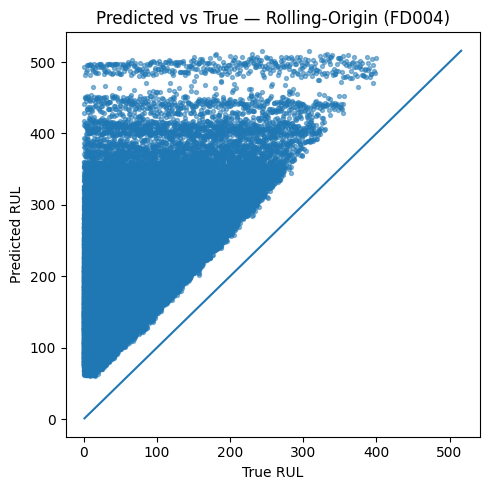


[PER-ENGINE MAE] (Top 10 worst engines)
118    254.672565
133    228.756391
173    213.627807
49     209.797585
179    209.323622
225    203.785242
171    193.355108
158    191.767531
37     188.955488
88     188.523408
dtype: float64


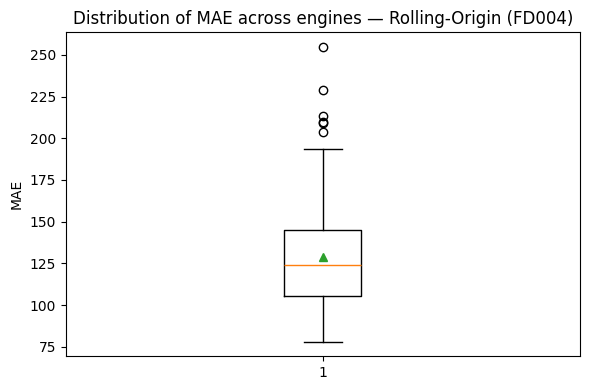

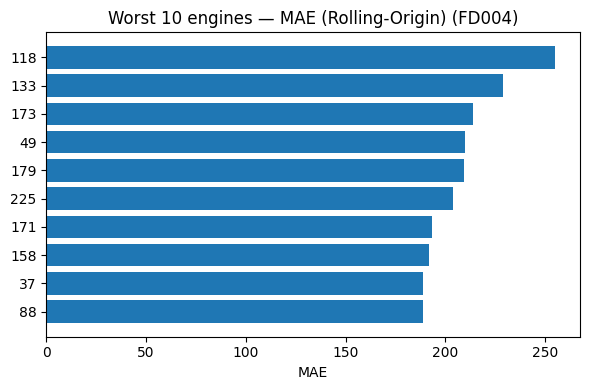


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -6.3807
    RMSE: 152.7098
     MAE: 139.9290
 sMAPE_%: 111.0654

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.6313 ± 0.0640
Without id/cycle : R²=0.5940 ± 0.0375


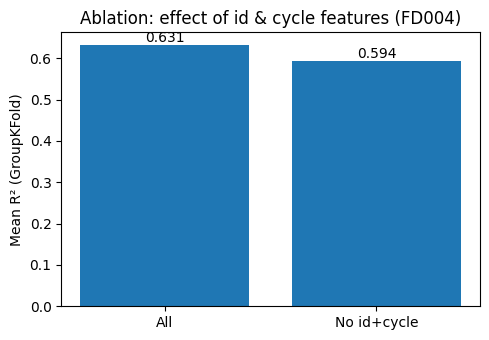


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 61249
Train (80%)   : 48999  → ratio=0.8000
Test  (20%)   : 12250  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 3153.14 seconds
CPU% at start        : 4.9%   (~0.13 GHz)
CPU% at end          : 22.5%   (~0.58 GHz)
Memory at start      : 1091.43 MB
Memory at end        : 1151.91 MB   (Δ 60.48 MB)


In [4]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD004"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "gbrf"

# Fixed model hyperparameters (as requested)
GB_PARAMS = dict(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)

RF_PARAMS = dict(
    n_estimators=100,
    max_depth=14,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ============================================
# Model training (GB + RF)
# ============================================
gb_model = GradientBoostingRegressor(**GB_PARAMS)
gb_model.fit(X_train, y_train)
y_gb = gb_model.predict(X_val)

rf_model = RandomForestRegressor(**RF_PARAMS)
rf_model.fit(X_train, y_train)
y_rf = rf_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_gb + 0.5 * y_rf

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_gb = print_block_metrics("GradientBoosting", y_val, y_gb)
m_rf = print_block_metrics("RandomForest",    y_val, y_rf)
m_ens= print_block_metrics("Ensemble",        y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_gb, m_rf, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations (TreeExplainer for tree models)
# ============================================
SHAP_SAMPLES = min(300, X_val.shape[0])  # small subset for speed
X_shap = X_val.sample(n=SHAP_SAMPLES, random_state=42)

def tree_shap_fast(model, X_explain_df, title_prefix, file_tag):
    # Fast TreeExplainer settings for tree models
    explainer = shap.TreeExplainer(
        model,
        feature_perturbation="tree_path_dependent",
        model_output="raw"
    )
    # Skip additivity check for speed; safe for visualization
    shap_vals = explainer.shap_values(X_explain_df, check_additivity=False)

    # Summary plot (saved)
    shap.summary_plot(shap_vals, X_explain_df, show=False)
    plt.title(f"SHAP Summary — {title_prefix} ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"SHAP_Summary_{file_tag}_{DATASET_NAME}.png")
    plt.show()

    # Single-row force plot (saved)
    row = X_explain_df.iloc[[0]]
    sv_row = np.asarray(explainer.shap_values(row, check_additivity=False))[0]
    expected_val = float(np.asarray(explainer.expected_value).mean())
    fig, ax = plt.subplots(figsize=(14, 3))
    _ = shap.force_plot(expected_val, sv_row, row.iloc[0].values,
                        feature_names=row.columns.tolist(), matplotlib=True, show=False)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    plt.tight_layout()
    save_png(f"Local_SHAP_force_{file_tag}_Single_{DATASET_NAME}.png")
    plt.show()

    return shap_vals

print("Computing SHAP (fast) for GradientBoosting...")
shap_vals_gb = tree_shap_fast(gb_model, X_shap, "GradientBoosting", "GradientBoosting")

print("Computing SHAP (fast) for RandomForest...")
shap_vals_rf = tree_shap_fast(rf_model, X_shap, "RandomForest", "RandomForest")

# Ensemble SHAP (only if shapes match)
if np.shape(shap_vals_gb) == np.shape(shap_vals_rf):
    shap_vals_ens = (np.asarray(shap_vals_gb) + np.asarray(shap_vals_rf)) / 2.0
    print("Plotting SHAP summary (Ensemble)...")
    shap.summary_plot(shap_vals_ens, X_shap, show=False)
    plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] Ensemble SHAP skipped (shape mismatch).")

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_gb)),       y_gb,           label="GradientBoosting",  marker='x')
plt.plot(range(len(y_rf)),       y_rf,           label="RandomForest",      marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",          marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

import warnings
warnings.filterwarnings("ignore")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_gb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", GradientBoostingRegressor(**GB_PARAMS))
])
pipe_rf = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", RandomForestRegressor(**RF_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_gb, name="GradientBoosting")
_ = cv_eval_pipeline(X, y, groups, pipe_rf, name="RandomForest")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_gb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", GradientBoostingRegressor(**GB_PARAMS))
    ])

def build_pipe_rf():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_gb, name="GradientBoosting"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf, name="RandomForest"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    # For tree models, scaling is usually irrelevant; still keep for symmetry/leakage demo
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_rf, name="RandomForest")
_ = cv_eval_pipeline(X, y, groups, build_pipe_rf(), name="RandomForest (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf,
    embargo_val=0,  name=f"Rolling-Origin RF (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf,
    embargo_val=10, name=f"Rolling-Origin RF (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_rf)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_rf)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")
